In [43]:
######################
minsep = 10.
maxsep = 90.
nbins = 15
nmult = 50
#npatch = 50
nbootstrap = 1000
brute = True

seed1 = 12936
seed2 = 19284

passivecrop = True
write = True
plot = True
config = {"min_sep": minsep, \
          "max_sep": maxsep, \
            "nbins": nbins, \
            "sep_units": 'degree', \
            "bin_type": 'Linear', \
            "brute": brute, \
            "metric": 'Arc', \
            #"var_method": 'bootstrap', \
            #"num_bootstrap": nbootstrap,\
            }
######################

import numpy as np
from astropy.io import ascii
from astropy.coordinates import SkyCoord
import astropy.units as u
from auger_tools import generate_RandomCatalogue

# Read UHECR
filename_e = '../data/Auger/events_a8_lb.dat'
events_a8 = ascii.read(filename_e)
# Galaxy Mask
eve = SkyCoord(events_a8['RA'],events_a8['dec'],frame='icrs',unit='degree')
mask_eve = np.where([abs(eve.galactic.b)>5.*(u.degree)])[1]
events_a8 = events_a8[mask_eve]

# Read Gxs
if passivecrop==True: filename_g = '../data/VLS/2MRSxWISE_VLS_passivecrop.txt'
else: filename_g = '../data/VLS/2MRSxWISE_VLS.txt'
data = ascii.read(filename_g)

# Bright/Faint
data_bright = data[(data['K_abs']<-23.2)&(data['K_abs']>-26.)]
data_faint = data[(data['K_abs']>-23.2)&(data['K_abs']<-22.)]

# Random Catalogue
rand_ra1, rand_dec1 = generate_RandomCatalogue(data_bright['_RAJ2000'],data_bright['_DEJ2000'],\
                                               nmult,seed1, mask=True)
rand_ra2, rand_dec2 = generate_RandomCatalogue(data_faint['_RAJ2000'],data_faint['_DEJ2000'],\
                                               nmult,seed2, mask=True)


In [44]:
# TreeCorr Catalogues
import treecorr

ecat = treecorr.Catalog(ra=events_a8['RA'], dec=events_a8['dec'], \
                        ra_units='deg', dec_units='deg')
rcat1 = treecorr.Catalog(ra=rand_ra1, dec=rand_dec1, \
                        ra_units='deg', dec_units='deg')
rcat2 = treecorr.Catalog(ra=rand_ra2, dec=rand_dec2, \
                        ra_units='deg', dec_units='deg')

dd = treecorr.NNCorrelation(config)
dr = treecorr.NNCorrelation(config)
rr = treecorr.NNCorrelation(config)
rd = treecorr.NNCorrelation(config)

xi1_bs = np.zeros((nbootstrap,nbins))
varxi1_bs = np.zeros((nbootstrap,nbins))
xi2_bs = np.zeros((nbootstrap,nbins))
varxi2_bs = np.zeros((nbootstrap,nbins))
for n in range(nbootstrap):
    databs = np.random.choice(data_bright,size=len(data_bright))
    gcat = treecorr.Catalog(ra=databs['_RAJ2000'], dec=databs['_DEJ2000'],\
                            ra_units='deg', dec_units='deg')

    rr.process(rcat1)
    dd.process(gcat,ecat)
    dr.process(gcat,rcat1)
    rd.process(ecat,rcat1)

    xi1_bs[n], varxi1_bs[n] = dd.calculateXi(rr=rr,dr=dr,rd=rd)


    """
    FAINT
    """
    databs = np.random.choice(data_faint,size=len(data_faint))
    gcat = treecorr.Catalog(ra=databs['_RAJ2000'], dec=databs['_DEJ2000'],\
                            ra_units='deg', dec_units='deg')

    rr.process(rcat2)
    dd.process(gcat,ecat)
    dr.process(gcat,rcat2)
    rd.process(ecat,rcat2)

    xi2_bs[n], varxi2_bs[n] = dd.calculateXi(rr=rr,dr=dr,rd=rd)


#### Plot

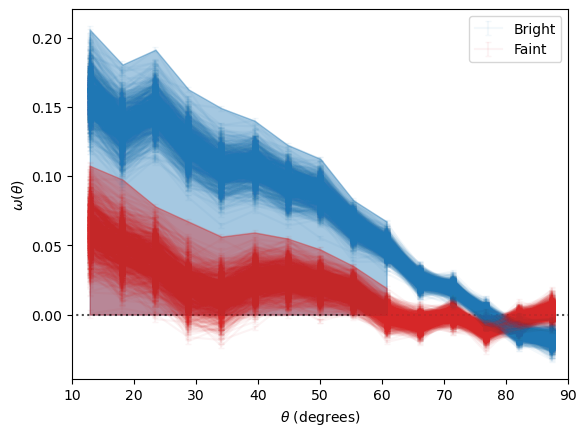

In [41]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

cutoff = 5

fig, ax = plt.subplots()

sig1 = np.sqrt(varxi1_bs)
sig2 = np.sqrt(varxi2_bs)

r = dd.meanr

ax.hlines(0.,0.,90.,ls=':',color='k',alpha=.7)
xi1_max = [np.max(xi1_bs[:,i]) for i in range(nbins)][:-cutoff]
xi2_max = [np.max(xi2_bs[:,i]) for i in range(nbins)][:-cutoff]
ax.fill_between(r[:-cutoff], y1=xi1_max, color='C0', alpha=.4)
ax.fill_between(r[:-cutoff], y1=xi2_max, color='C3', alpha=.4)

alpha=.05
capsize = 2
for i in range(nbootstrap):
    ax.errorbar(r, xi1_bs[i], yerr=sig1[i], color='C0', label='Bright',\
                alpha=alpha, capsize=capsize)
    ax.errorbar(r, xi2_bs[i], yerr=sig2[i], color='C3', label='Faint',\
                alpha=alpha, capsize=capsize)

handles, labels = ax.get_legend_handles_labels()
ax.legend([handles[0],handles[1]], [labels[0],labels[1]], loc='best')

ax.set_xlabel(r'$\theta$ (degrees)')
ax.set_ylabel(r'$\omega(\theta)$')

ax.set_xlim([minsep,maxsep])

ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

# if plot==True:
#     plotname = f'../data/cross_treecorr_bf_{nmult}'
#     if passivecrop==True: plotname+='_passivecrop'
#     plt.savefig(plotname+'.png')

plt.show()


#### Integration

In [42]:
from scipy import integrate

int_b = np.zeros(nbootstrap)
int_f = np.zeros(nbootstrap)
cutoff = 5
for i in range(nbootstrap):

    int_b[i] = integrate.simpson(xi1_bs[i][:-cutoff],x=r[:-cutoff])
    int_f[i] = integrate.simpson(xi2_bs[i][:-cutoff],x=r[:-cutoff])

ratio_int = int_b/int_f
print(np.mean(ratio_int),r'$\pm$',np.std(ratio_int)/np.sqrt(nbootstrap))

4.976289626855387 $\pm 3.8736401942710272


In [38]:
[np.max(xi1_bs[:,i]) for i in range(nbins)]

[0.2058042100015721,
 0.18056788623922865,
 0.19131210684672448,
 0.16263585732646127,
 0.14906474232042388,
 0.14007642945652943,
 0.122525009340918,
 0.11246162702205692,
 0.0825326942237662,
 0.06724143782958843,
 0.037410231777380176,
 0.031075519704379422,
 0.011786999927372437,
 -0.00037549488627827227,
 -0.00333954890907273]